In [12]:
%pylab notebook --no-import-all
%matplotlib notebook

from astropy.table import Table
    
from numba import jit

from scipy import misc
from scipy import optimize as opt

import sympy as sp
sp.init_printing(use_latex=True, use_unicode=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
PI      = np.pi
TWO_PI  = 2.*PI
FOUR_PI = 4.*PI

# (#1) Landau 5.16 #3

In [4]:
def gauss_rs_0(a, b, y, wp):
    x = (a*b*(1. + y)) / ((b + a) - y*(b-a))
    w = ((2.*a*b**2.)/(b+a - (b - a)*y)**2.)*wp
    
    return x, w

def gauss_int(func, x):
    a = x[0]
    b = x[-1]
    
    yi, wi = np.polynomial.legendre.leggauss(len(x))
    
    int_x = 0.
    int_w = 0.
    
    if a == 0.:
        md = (b - a) / 2.
        A  = (md * b) / (b - md)
        
        int_x, int_w = gauss_rs_0(A, b, yi, wi)
    else:
        int_x = yi
        int_w = wi
    
    return np.dot(func(int_x), int_w)

In [29]:
def elliptical(m):
    return lambda t: (1. - m*(np.sin(t)**2.))**(-0.5)

@jit
def elliptical_approx(m):
    a0 = 1.3862944
    b0 = 0.5
    a1 = 0.1119723
    b1 = 0.1213478
    a2 = 0.0725296
    b2 = 0.0288729
    
    m1 = 1. - m
    
    return a0 + (a1*m1) + (a2*m1**2.) - (b0 + (b1*m1) + (b2*m1**2.))*np.log(m1)

@jit
def search_elliptical(m, tol=3e-5, limit=4000):
    err = 1.
    N   = 10
    intval = -1.
    
    while err > tol:
        x = np.linspace(0, PI/2., N)
        
        intval = gauss_int(elliptical(m), x)
        approx = elliptical_approx(m)
        
        err = np.abs(intval - approx)
        N  *= 2
        
        if N > limit:
            print('Exceeded iteration limit')
            break
    
    return intval, err, N

A test value of $m = 0.5$ to check if the search algorithm works:

In [30]:
search_elliptical(0.5)

With 20 points used in the Gaussian quadrature, the search algorithm converged with the polynomial approximation!

# (#2) Landau 5.16 #4

For this problem we need a modification to the quadrature weights since there is a $1/\sqrt{1-y^2}$ that appears. For the integral, $$\frac{T}{T_0} = \frac{1}{\pi}\int_0^{\theta_m}\ d\theta\left[\sin^2\left(\frac{\theta_m}{2}\right) - \sin^2\left(\frac{\theta}{2}\right)\right]^{-1/2}$$ 

let $c = \sin(\theta_m / 2)$ (since $\theta_m$ is constant in the integrand) and extract it from the radical: $$\frac{T}{T_0} = \frac{1}{c\pi}\int_0^{\theta_m}\ d\theta\left[1 - \frac{1}{c^2}\sin^2\left(\frac{\theta}{2}\right)\right]^{-1/2}$$

Next, perform a substitution $y = \frac{1}{c}\sin\left(\frac{\theta}{2}\right)$: 
$$dy = \frac{1}{2c}\cos\left(\frac{\theta}{2}\right)d\theta$$
$$dy^2 = \frac{1}{4c^2}\cos^2\left(\frac{\theta}{2}\right)d\theta^2$$
$$dy^2 = \frac{1}{4c^2}\left[1 - \sin^2\left(\frac{\theta}{2}\right)\right]d\theta^2$$
$$dy^2 = \frac{1}{4c^2}\left[1 - c^2y^2\right]d\theta^2$$
$$\Rightarrow\ d\theta = \frac{2c\ dy}{\sqrt{1 - c^2y^2}}$$

Conveniently, this substitution also has the integration bounds set to $y : 0\rightarrow 1$. This means the converted integral is $$\frac{T}{T_0} = \frac{2}{\pi}\int_0^1 dy\ \frac{\left(1 - c^2y^2\right)^{-1/2}}{\sqrt{1 - y^2}}$$

This kind of integral requires **Gauss-Chebyshev quadrature** rather than regular Gauss-Legendre quadrature. Therefore, we need a new integration function:

In [5]:
def gauss_int_cheb(func, x):
    a = x[0]
    b = x[-1]
    
    yi, wi = np.polynomial.chebyshev.chebgauss(len(x))
    
    int_x = 0.
    int_w = 0.
    
    if a == 0.:
        md = (b - a) / 2.
        A  = (md * b) / (b - md)
        
        int_x, int_w = gauss_rs_0(A, b, yi, wi)
    else:
        int_x = yi
        int_w = wi
    
    return np.dot(func(int_x), int_w)

The remaining functions define the actual function we are integrating $$F(y) = \frac{1}{\sqrt{1 - c^2y^2}}$$ and the Taylor approximation for the integral. To speed up the calculation, I've imported a `numba`'s `jit` module to compile some of the functions to machine language.

In [10]:
def elliptical2(tm):
    # Converted c^(-1)(1 - (1/c^2)sin^2(t / 2))^(-1/2)
    # to 2/√(1-c^2y^2) for Gauss-Chebyshev Quadrature
    # from y : 0 -> 1
    c = np.sin(tm / 2.)
    
    return lambda y: (1. - (c*y)**2.)**(-0.5)

def eapprox_coeff(N):
    # Using the scipy double factorial routine to reduce overhead
    return np.array([(misc.factorial2((2*(i) - 1))/misc.factorial2(2*(i)))**2. for i in np.arange(N)])

@jit
def elliptical_approx2(m, N):
    x = np.sin(m)**2.
    c = eapprox_coeff(N)
    y = x**np.arange(N)
    
    return np.dot(c, y)

@jit
def int_elliptical2(m, tol=3e-5, limit=4000):
    # First ask if the input is array, to effectively create a polymorphism
    if type(m) is np.ndarray:
        intvals = np.zeros(len(m))
        errs    = np.zeros(len(m))
        
        for i in range(len(m)):
            intvals[i], errs[i] = int_elliptical2(m[i], tol, limit)
        
        return intvals, errs
    # The actual calculation
    else:
        err = 1.
        N   = 2
        intval = -1.
        last   = -99.
        coeff  = 2. / PI

        while err > tol:
            x = np.linspace(0, 1, N)

            intval = coeff * gauss_int_cheb(elliptical2(m), x)
            err    = np.abs(intval - last)

            last = intval
            N   += 1
            
            # Infinite loop protection
            if N > limit:
                print('Exceeded iteration limit')
                err = -999. # Just an indication that there was no convergence
                break

        return intval, err

@jit
def find_approx2(m, tol=3e-5):
    if type(m) is np.ndarray:
        vals = np.zeros(len(m))
        errs = np.zeros(len(m))
        Ns   = np.zeros(len(m))
        
        for i in range(len(m)):
            vals[i], errs[i], Ns[i] = find_approx2(m[i], tol)
        
        return vals, errs, Ns
    
    else:
        err  = 1.
        N    = 1
        last = -99.
        val  = -99.

        while err > tol:
            val = elliptical_approx2(m, N)
            err = np.abs(val - last)

            last = val
            N   += 1

        return val, err, N

Firstly, let's demonstrate that the integration is working:

In [17]:
x = np.linspace(0 + 0.5, PI - 0.5, 5)

def make_table_1(x, tol=1e-4):
    intvals, errs = int_elliptical2(x, tol)
    
    return Table({
        '$\\theta_m$': x,
        '$K = \\frac{T}{T_0}$': intvals,
        '$|\\delta K|$': errs
    })

make_table_1(x)

$\theta_m$,$K = \frac{T}{T_0}$,$|\delta K|$
float64,float64,float64
0.5,1.01187770593,1.34640164282e-05
1.0353981634,1.05334726853,8.77041224356e-06
1.57079632679,1.13391372472,2.12082361857e-05
2.10619449019,1.27886582518,3.33639259631e-05
2.64159265359,1.57439564107,8.30833285452e-05


Now, test the Taylor approximation:

In [18]:
x = np.linspace(0.01, 0.99, 5)

def make_table_2(x, tol=1e-4):
    intvals, errs, Ns = find_approx2(x, tol)
    
    return Table({
        '$\\theta_m$': x,
        '$K = \\frac{T}{T_0}$': intvals,
        '$|\\delta K|$': errs,
        '$N$ (Number of terms)': Ns
    })

make_table_2(x)

$\theta_m$,$K = \frac{T}{T_0}$,$|\delta K|$,$N$ (Number of terms)
float64,float64,float64,float64
0.01,1.00002499917,2.49991666779e-05,3.0
0.255,1.01650141135,2.51558886171e-05,5.0
0.5,1.06632487651,3.88519495855e-05,7.0
0.745,1.15943233506,7.68393032831e-05,10.0
0.99,1.32003588844,9.68534626267e-05,17.0


Notice that the Taylor approximation diverges for $\theta_m\sim 1$. This is demonstrated visually in the following plot:

<IPython.core.display.Javascript object>


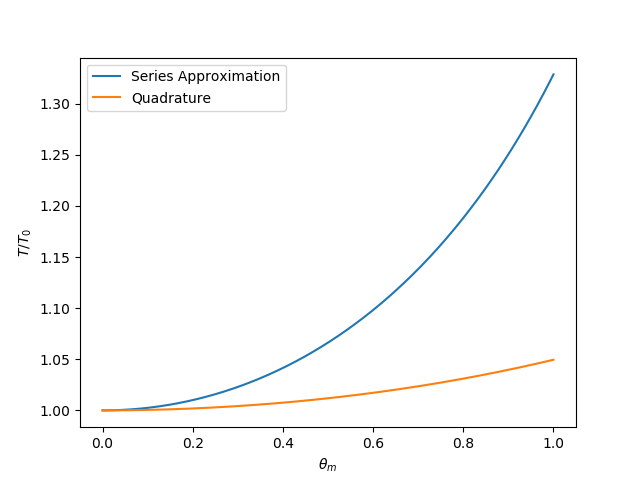

In [19]:
x = np.linspace(0, 1, 1000)

approx, aerr, aN = find_approx2(x, tol=1e-4)
intval, ierr     = int_elliptical2(x, tol=1e-4)

plt.plot(x, approx, label='Series Approximation')
plt.plot(x, intval, label='Quadrature')
plt.xlabel('$\\theta_m$')
plt.ylabel('$T/T_0$')
plt.legend(loc='upper left')

# (#3) Squashed Galaxies

There are a couple approaches that could be done to tackle this question. I elected to use a 2D polar Monte-Carlo mean-value integrator:

In [20]:
@jit
def mc_integrate2d_r(func, R, T, N, iterations=0):
    # Integrates a polar region r: [R0, R1] and t: [T0, T1]
    # The function MUST include the r measure of integration
    
    if iterations > 1:
        vals = np.zeros(iterations)
        
        i = 0
        
        while i < iterations:
            val, err= mc_integrate2d_r(func, R, T, N)
            vals[i] = val
            
            i += 1
        
        return np.mean(vals), np.std(vals)
    else:
        r, t = rand_circle(R, T, N)

        f  = func(r, t)

        mu = np.mean(f)
        s  = np.std(f)

        return (R[1] - R[0]) * (T[1] - T[0]) * mu, (R[1] - R[0]) * (T[1] - T[0])* (s / np.sqrt(N))

def rand_circle(r, t, N):
    if (type(r) is list) or (type(r) is np.ndarray):
        return (r[1] - r[0]) * np.random.rand(N) + r[0], (t[1] - t[0]) * np.random.rand(N) + t[0]
    else:
        return r * np.random.rand(N), t * np.random.rand(N)

Again, I used the `jit` module to help Python get a bit of a boost with the number crunching.

To get the fraction of admitted light, I took the integral of $\frac{I}{A}$ over polar coordinates. I chose a polar configuration because using Cartesian coordinates would introduce a dependency on $x$ (or $y$) in the limits of integration.

The fraction is actually a relation to the totally circular admitted light ($b = a$), so I used the integral of $\frac{I}{A}\big|_{b/a = 1}$ as a normalization factor. I suppose $I_{\text{exp}}\big|_{b/a=1}$ is actually solvable analytically, but I didn't bother with that. To minimize the error, I took 10 iterations of the Monte-Carlo integration to find a suitable mean and standard deviation (which can be viewed as the error).

The source code:

In [21]:
def iexp(ba):
    c = ba**(-2.)
    
    def ret(r, t):
        _r = r * (np.cos(t)**2. + c*np.sin(t)**2.)**(0.5)
        
        return r * np.exp((-1.678 / 2.) * _r)
    
    return ret

def idev(ba):
    c = ba**(-2.)
    
    def ret(r, t):
        _r = r * (np.cos(t)**2. + c*np.sin(t)**2.)**(0.5)
        
        return r * np.exp(-((3466. / 2.) * _r)**(0.25))
    
    return ret

@jit
def fraction_exp(ba, ba_max=1, N=10000, iterations=10):
    if type(ba) is np.ndarray:
        vals = np.zeros(len(ba))
        errs = np.zeros(len(ba))
        i = 0
        
        while i < len(ba):
            out = fraction_exp(ba[i], ba_max=ba_max, N=N, iterations=iterations)
            vals[i] = out[0]
            errs[i] = out[1]
            
            i += 1
        
        return vals, errs
    else:
        num, snum = mc_integrate2d_r(iexp(ba), [0., 1.], [0., TWO_PI], N, iterations=iterations)
        den, sden = mc_integrate2d_r(iexp(ba_max), [0., 1.], [0., TWO_PI], N, iterations=iterations)
        
        return np.array([num / den, ((snum / den)**2. + ((num / den**2.)*sden)**2.)**(0.5)])
    
@jit
def fraction_dev(ba, ba_max=1, N=10000, iterations=10):
    if type(ba) is np.ndarray:
        vals = np.zeros(len(ba))
        errs = np.zeros(len(ba))
        i = 0
        
        while i < len(ba):
            out = fraction_dev(ba[i], ba_max=ba_max, N=N, iterations=iterations)
            vals[i] = out[0]
            errs[i] = out[1]
            i += 1
        
        return vals, errs
    else:
        num, snum = mc_integrate2d_r(idev(ba), [0., 1.], [0., TWO_PI], N, iterations=iterations)
        den, sden = mc_integrate2d_r(idev(ba_max), [0., 1.], [0., TWO_PI], N, iterations=iterations)
        
        return np.array([num / den, ((snum / den)**2. + ((num / den**2.)*sden)**2.)**(0.5)])

Now, to plot the two models. I use `c` for the fraction $b/a$:

<IPython.core.display.Javascript object>


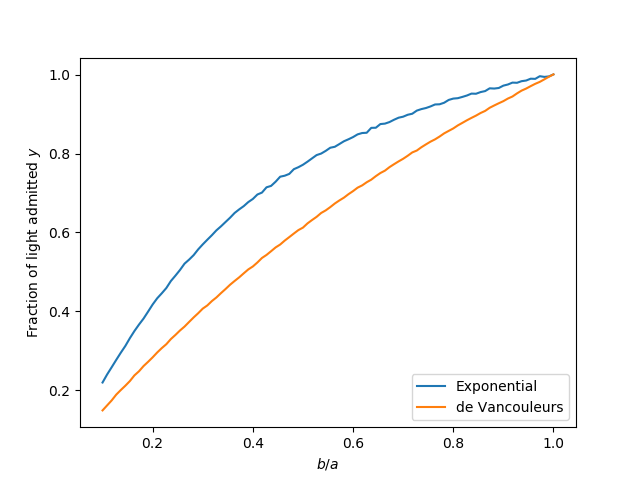

In [27]:
c = np.linspace(0.1, 1., 100)

mu_exp, s_exp = fraction_exp(c)
mu_dev, s_dev = fraction_dev(c)

plt.figure()
plt.plot(c, mu_exp, label='Exponential')
plt.plot(c, mu_dev, label='de Vancouleurs')
plt.legend(loc='lower right')
plt.xlabel('$b / a$')
plt.ylabel('Fraction of light admitted $y$')

And the errors:

<IPython.core.display.Javascript object>


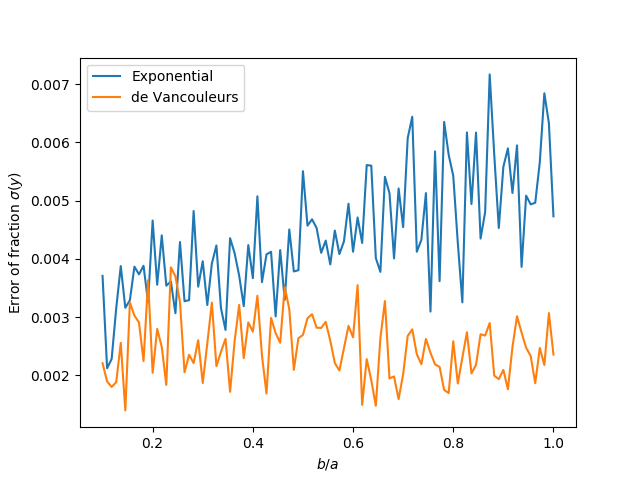

In [28]:
plt.figure()
plt.plot(c, s_exp, label='Exponential')
plt.plot(c, s_dev, label='de Vancouleurs')
plt.legend(loc='upper left')
plt.xlabel('$b/a$')
plt.ylabel('Error of fraction $\\sigma(y)$')

The de Vancouleurs model has both a more stable error around $\sim 2.5\times10^{-3}$ and a flatter slope. The exponential model bows out a bit more and has a linear correlation to $b/a$!

I wanted to be sure that this integration implementation worked, so I checked against Mathematica's numerical integration routines; it worked!